# Navigation

---

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

from dqn_agent import Agent
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training Loop

The next code cell contains the training loop for the Deep Q-Learning algorithm. 

This implementation makes use of the three improvements shown in the course. The Double DQN, Prioritized Experience Replay, and the Dueling Q Networks can be turned on and off with the respective constructor parameters for the agent. 

In [5]:
n_episodes=2000
eps_start=1.0
eps_end=0.01
eps_decay=0.995

agent = Agent(state_size=state_size, action_size=action_size, seed=0, 
              double_dqn=True, dueling_network=True, priority_replay=True)

scores = []
B_values = []
eps_values = []
scores_window = deque(maxlen=100)
eps = eps_start
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]       # reset the environment
    state = env_info.vector_observations[0]                 # get the current state
    score = 0                                               # initialize the score
    while True:
        action = agent.act(state, eps)                      # select an action
        env_info = env.step(action)[brain_name]             # send the action to the environment
        next_state = env_info.vector_observations[0]        # get the next state
        reward = env_info.rewards[0]                        # get the reward
        done = env_info.local_done[0]                       # see if episode has finished
        agent.step(state, action, reward, next_state, done) # update the agent based on the chosen action and reward
        score += reward                                     # update the score
        state = next_state                                  # roll over the state to next time step
        if done:                                            # exit loop if episode finished
            break
    scores_window.append(score)
    scores.append(score)
    B_values.append(agent.B)
    eps_values.append(eps)
    eps = max(eps_end, eps_decay*eps)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=13.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break


Episode 100	Average Score: 1.17
Episode 200	Average Score: 3.73
Episode 300	Average Score: 6.60
Episode 400	Average Score: 9.61
Episode 500	Average Score: 12.51
Episode 522	Average Score: 13.00
Environment solved in 422 episodes!	Average Score: 13.00


### 4. Plotting Rewards

Next we plot the scores over time to show how the agent is performing over time. We also plot the B and Epsilon values change over time. This is an indicator to show how these moving paramters affect the training process over time. 

The B values shown in red are the scaling factors for the importance sampling weight. The Epsilon values shown in green are the probabilities of choosing a random action or choosing a greedy action based on the current policy. 

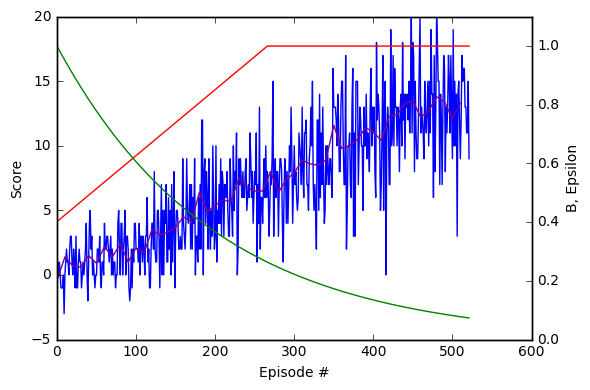

In [6]:
fig, ax1 = plt.subplots()

end_idx = (len(scores) % 10)
means = np.mean(np.array(scores[:-end_idx]).reshape(-1,10), axis=1)
y_values = np.arange(0, len(scores), int(len(scores)/len(means)))[:-1]

color1 = 'blue'
color2 = 'purple'
ax1.set_xlabel('Episode #')
ax1.set_ylabel('Score')
ax1.plot(np.arange(len(scores)), scores, color=color1)
ax1.plot(y_values, means, color=color2)

ax2 = ax1.twinx()

axes = plt.gca()
axes.set_ylim([None,1.1])

color3 = 'red'
color4 = 'green'
ax2.set_ylabel('B, Epsilon')
ax2.plot(np.arange(len(B_values)), B_values, color=color3)
ax2.plot(np.arange(len(eps_values)), eps_values, color=color4)

fig.tight_layout()
plt.show()

### 5. Watching the Trained Agent

Finally this code cell shows how a trained agent will perform. You can watch the agent collect bananas in the Unity Environment visualization. 

In [ ]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, 
              double_dqn=True, dueling_network=True, priority_replay=True)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
n_episodes = 5
test_scores = []
test_scores_window = deque(maxlen=100)
eps_test = 1e-5
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state,eps_test)             # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    test_scores_window.append(score)
    test_scores.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(test_scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(test_scores_window)))
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(test_scores)), test_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()